In [68]:
import mediapipe as mp
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.utils as utils
from datetime import datetime
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [69]:
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands

In [70]:
classes = [chr(ord) for ord in range(65,91)]

In [71]:
classes.append("Space")

In [72]:
classes = tuple(classes)

In [73]:
hands = mp_hands.Hands(min_detection_confidence=0.7, static_image_mode=True, max_num_hands=1)

In [75]:
data = []
labels = []

for class_index, gesture_class in enumerate(classes):
    for i, filename in tqdm(enumerate(os.listdir(f"../data/train/{gesture_class}"))):
        try:
            image = cv2.imread(f"../data/train/{gesture_class}/{filename}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # changes from bgr to rgb since cv2 is bgr but mediapipe requires rgb
        except:
            continue
        image.flags.writeable = False
        if i%2 == 0:
            image = cv2.flip(image, 1)
        results = hands.process(image) # this makes the actual detections

        landmarks = []
        if results.multi_hand_landmarks:
            for landmark in results.multi_hand_landmarks[0].landmark:
                x, y = landmark.x, landmark.y
                landmarks.append([x,y])
            label = np.zeros([len(classes)])
            label[class_index] = 1
            data.append(landmarks)
            labels.append(label)

5996it [04:07, 24.21it/s]
5996it [04:17, 23.33it/s]
5996it [04:09, 24.02it/s]
5996it [03:39, 27.34it/s]
5996it [04:29, 22.23it/s]
5996it [04:19, 23.06it/s]
5996it [04:08, 24.09it/s]
5996it [04:11, 23.82it/s]
5996it [04:11, 23.80it/s]
5996it [04:08, 24.12it/s]
5996it [07:04, 14.14it/s]
5996it [04:07, 24.20it/s]
5996it [15:02,  6.64it/s]
5996it [16:29,  6.06it/s]
5996it [24:09,  4.14it/s]
5996it [46:27,  2.15it/s] 
5996it [24:41,  4.05it/s] 
5966it [04:12, 23.59it/s]
5996it [04:09, 24.04it/s]
5648it [03:58, 23.70it/s]
4542it [03:11, 23.77it/s]
5996it [04:15, 23.46it/s]
5996it [04:09, 24.01it/s]
5996it [04:09, 24.04it/s]
5720it [03:59, 23.86it/s]
5996it [04:06, 24.34it/s]
5886it [03:27, 28.37it/s]


In [76]:
data = torch.tensor(data)
labels = torch.tensor(labels)

In [82]:
data.shape

torch.Size([146554, 21, 2])

In [78]:
# import pickle
# with open("../data/data.pkl", 'wb') as file:
#     pickle.dump(data, file)
# with open("../data/labels.pkl", 'wb') as file:
#     pickle.dump(labels, file)

In [83]:
train_data, val_data, train_labels, val_labels = train_test_split(data, labels, shuffle=True)

In [84]:
hands = mp_hands.Hands(min_detection_confidence=0.001, static_image_mode=True, max_num_hands=1)

In [16]:
test_data = []
test_labels = []

for class_index, gesture_class in tqdm(enumerate(classes), unit=" classes", desc="Processing Items"):
    for filename in os.listdir(f"../data/test/{gesture_class}"):
        try:
            image = cv2.imread(f"../data/test/{gesture_class}/{filename}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # changes from bgr to rgb since cv2 is bgr but mediapipe requires rgb
        except:
            continue
        image.flags.writeable = False
        results = hands.process(image) # this makes the actual detections

        landmarks = []
        if results.multi_hand_landmarks:
            for landmark in results.multi_hand_landmarks[0].landmark:
                x, y = landmark.x, landmark.y
                landmarks.append([x,y])
            test_label = np.zeros([len(classes)])
            test_label[class_index] = 1
            test_data.append(landmarks)
            test_labels.append(test_label)

Processing Items: 27 classes [00:05,  5.26 classes/s]


In [17]:
test_data = torch.tensor(test_data)
test_labels = torch.tensor(test_labels)

In [85]:
class LandmarksDataset(utils.data.Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.len = len(y)
        self.transform = transform
    def __len__(self):
        return self.len
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [86]:
training_set = LandmarksDataset(train_data, train_labels)
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)

In [87]:
validation_set = LandmarksDataset(val_data, val_labels)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

In [88]:
test_set = LandmarksDataset(test_data, test_labels)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=False)

In [89]:
class HandNetwork(nn.Module):
    def __init__(self):
        super(HandNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(42, 120)
        self.fc2 = nn.Linear(120, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, len(classes))
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        return x

In [108]:
model = HandNetwork()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.1)

In [109]:
def train_one_epoch(curr_model):
    running_loss = 0
    last_loss = 0

    for i, data in enumerate(training_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = curr_model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward() # calculate the gradients
        optimizer.step() # update the params

        running_loss += loss.item()
        if i % 500 == 500-1:
            last_loss = running_loss / 500 # loss per batch
            print(f'  batch {i+1} loss: {last_loss}')
            running_loss = 0
    
    return last_loss

EPOCH 1:
  batch 500 loss: 3.291951558709145
  batch 1000 loss: 3.2854449266195296
  batch 1500 loss: 3.2798778759241105
  batch 2000 loss: 3.271049015760422
  batch 2500 loss: 3.2524211324453356
  batch 3000 loss: 3.226501616001129
  batch 3500 loss: 3.135888165652752
  batch 4000 loss: 2.9161784588098527
  batch 4500 loss: 2.5723186208680273
  batch 5000 loss: 2.1946498931869867
  batch 5500 loss: 1.7133658626228572
  batch 6000 loss: 1.3702675198614598
  batch 6500 loss: 1.2396998058967292
  batch 7000 loss: 1.1105683126032817
  batch 7500 loss: 1.0534648515495937
  batch 8000 loss: 0.9416265707058483
  batch 8500 loss: 0.959827609001426
  batch 9000 loss: 0.8484199686181965
  batch 9500 loss: 0.7025062396142748
  batch 10000 loss: 0.6788454892197624
  batch 10500 loss: 0.5662436739135446
  batch 11000 loss: 0.5305625099634345
  batch 11500 loss: 0.5177961312113112
  batch 12000 loss: 0.5214467175775354
  batch 12500 loss: 0.4459445121842291
  batch 13000 loss: 0.4329548508489643
  

Text(0, 0.5, 'Validation Loss')

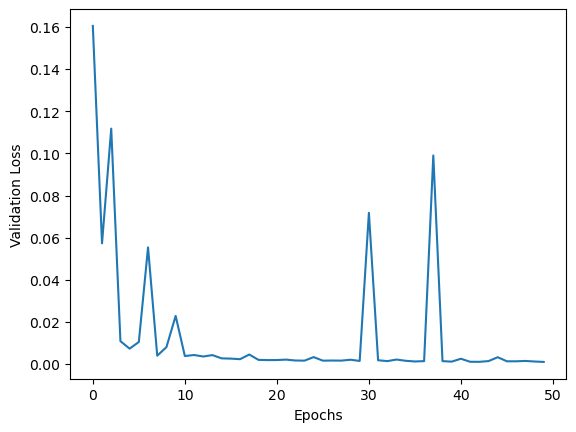

In [110]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

#This is doing some logging that we don't need to worry about right now.
epoch_number = 0
EPOCHS = 50
best_vloss = 1_000_000.
val_history = []
best_model = model

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    
    model.train(True)
    
    avg_loss = train_one_epoch(curr_model=model)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    val_history.append(avg_vloss.detach().numpy())
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        torch.save(model, "../models/model.pth")
    epoch_number += 1

plt.plot(range(EPOCHS), val_history)
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")

In [111]:
best_vloss

tensor(0.0010, dtype=torch.float64, grad_fn=<DivBackward0>)

In [112]:
import torch.nn.functional as F
from sklearn.metrics import f1_score

In [117]:
model = torch.load("../models/model.pth")

In [118]:
model.eval()
correct_count = 0
total = len(test_set)
with torch.no_grad():
    for i, tdata in enumerate(test_loader):
        inputs, labels = tdata
        outputs = torch.argmax(model(inputs), dim=1)
        labels = torch.argmax(labels, dim=1)
        correct_count += (outputs==labels).sum().item()

In [119]:
correct_count/total

1.0

In [120]:
f1_score(np.argmax(model(test_data).detach().numpy(), axis=1), np.argmax(test_labels.detach().numpy(), axis=1), average='weighted')

1.0

from sklearn.neighbors import KNeighborsClassifier

In [45]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [46]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_data.view(-1,21*2), train_labels)
y_pred = knn.predict(test_data.view(-1,21*2))
accuracy_score(test_labels, y_pred)

1.0

In [39]:
from sklearn.linear_model import RidgeClassifierCV

In [40]:
train_data.shape

torch.Size([1102, 21, 2])

In [41]:
clf = RidgeClassifierCV()
clf.fit(train_data.view(-1, 21*2), train_labels)
y_pred = clf.predict(val_data.view(-1, 21*2))
accuracy_score(val_labels, y_pred)

0.7364130434782609

In [42]:
F.softmax(torch.tensor(clf.decision_function(val_data.view(-1, 21*2))))

/var/folders/xw/slcw2lz14snfvxp49xgqmr880000gn/T/ipykernel_10494/1044316036.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(torch.tensor(clf.decision_function(val_data.view(-1, 21*2))))


tensor([[0.0313, 0.0347, 0.0300,  ..., 0.0333, 0.0364, 0.0284],
        [0.0302, 0.0299, 0.0406,  ..., 0.0398, 0.0329, 0.0293],
        [0.0291, 0.0329, 0.0322,  ..., 0.0373, 0.0327, 0.0262],
        ...,
        [0.0321, 0.0456, 0.0328,  ..., 0.0455, 0.0309, 0.0308],
        [0.0301, 0.0281, 0.0318,  ..., 0.0271, 0.0306, 0.0297],
        [0.0308, 0.0270, 0.0341,  ..., 0.0257, 0.0334, 0.0357]],
       dtype=torch.float64)

In [43]:
clf.score(val_data.view(-1, 21*2), val_labels)

0.7364130434782609

In [44]:
from sklearn.svm import LinearSVC

In [111]:
clf = LinearSVC(multi_class="ovr")
clf.fit(train_data.view(-1, 21*2), torch.argmax(train_labels, dim=1))
clf.score(val_data.view(-1, 21*2), torch.argmax(val_labels, dim=1))

/Users/reetinav/anaconda3/envs/PIC16B/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


0.8888888888888888

In [112]:
F.softmax(torch.tensor(clf.decision_function(val_data.view(-1, 21*2))), dim=1)

tensor([[0.5952, 0.0090, 0.0528,  ..., 0.0620, 0.0913, 0.0809],
        [0.5499, 0.0127, 0.0850,  ..., 0.0669, 0.0768, 0.0737],
        [0.5842, 0.0089, 0.0531,  ..., 0.0594, 0.0923, 0.0878],
        ...,
        [0.0690, 0.1502, 0.1629,  ..., 0.1562, 0.0389, 0.0815],
        [0.0903, 0.0719, 0.4556,  ..., 0.0353, 0.1396, 0.1260],
        [0.0648, 0.0662, 0.5327,  ..., 0.0554, 0.0969, 0.1004]],
       dtype=torch.float64)